### aim: combine streamlined-flux-corr-maker.ipynb, work_out_hosing.ipynb, and looping directory

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import os
import sys

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import snippets as sp
reload(sp)
import os
from datetime import date

In [4]:
dir(sp)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'sniplist',
 'tdf',
 'tfig',
 'tmask',
 'tmetro',
 'tmodi',
 'txr',
 'tylist']

## produce file that has flux correction in it

originally worked out in hosing/streamlined-flux-corr-maker.ipynb - this is the monthly wfo field difference of the salinity restored run minus the non-salinity-restored run, taken as a 40 year average 1980-2019 inclusive. 



In [5]:
make = False
if make:

    tvar = 'wfo'
    
    KDD0 = xr.open_dataset(f'./data/KDD0_{tvar}.nc')
    KWD0 = xr.open_dataset(f'./data/KWD0_{tvar}.nc')

    KWD0_clim = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")
    KDD0_clim = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")
    
  
    tmask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/mesh_mask3_6.nc')

    KWD = KWD0_clim.weighted(tmask.csize).mean(dim = ['y','x'])
    KDD = KDD0_clim.weighted(tmask.csize).mean(dim = ['y','x'])

    KWD0_40y = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")
    KDD0_40y = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")

    diff_D = KDD0_40y - KWD0_40y

    mean_ts = diff_D.weighted(tmask.csize).mean(dim = ['y','x'])

    plt.plot(np.arange(1,13), mean_ts.wfo.values)
    plt.title('global avg mean wfo diff, monthly \n (yearly mean v small: 2.3778268618516067e-08 kg/m2/s)')

    diff_D = diff_D.rename({"month": "time"})
    diff_clim = diff_D.wfo.values
    print(np.shape(diff_clim))

    #days of year
    nlys = np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335,366])
    lys = np.array([1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336,367])

    lydiff = np.zeros([366,149,182])
    nlydiff = np.zeros([365,149,182])

    #corrector
    for i in range(0,12):

        lydiff[lys[i]-1:lys[i+1]-1,:,:] = diff_clim[i,:,:]
        nlydiff[nlys[i]-1:nlys[i+1]-1,:,:] = diff_clim[i,:,:]

    ds = xr.Dataset({
        'lydiff': (('dim0', 'dim1', 'dim2'), lydiff),
        'nlydiff': (('dim05', 'dim1', 'dim2'), nlydiff),
    })
    
    ds.attrs['description'] = 'global difference in wfo [sal rest - no sal rest] from 40 yrs of 2 runs, daily for leap years and non leap years (from monthly model output), see AMOC-PLANKTOM/hosing/universal-forcing-maker'

    # Save to NetCDF
    ds.to_netcdf('./helper-fields/flxcorr.nc')

## produce a field for the universal hosing, by default 0.3 Sv, 

In [6]:
make = False

def make_universal_hosing(hos_sv = 0.3):
    tgrid = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

    array = tgrid['tmask'][0,0,:,:]
    hosar = np.copy(tgrid['tmask'][0,0,:,:])
    hosar[110:150,79:156] = 10
    hosar[124:150,20:80] = 10
    hosar[np.where(array == 0)] = 0
    hosar[np.where(hosar == 1)] = 0

    plt.pcolormesh(hosar)
    tgrid_m2 = tgrid['tmask'][0,0,:,:] * tgrid['e1t'][0,:,:]\
    * tgrid['e2t'][0,:,:]
    tgrid_m2 = tgrid_m2.values
    tgrid_m2[hosar < 6] = 0
    plt.figure()
    w = plt.pcolormesh(hosar)
    plt.colorbar(w)

    tot_ar = (np.sum(tgrid_m2))
    hosing = hos_sv * 1e6 ## cubic meters
    hosing_m = hosing/(np.sum(tot_ar))
    print(hosing_m)
    hosing_kg = hosing_m * 1e3 ## kg
    print(hosing_kg)

    hosar_val = np.copy(hosar).astype(float)
    hosar_val[hosar > 0] = hosing_kg
    plt.figure()
    w = plt.pcolormesh(hosar_val)
    plt.colorbar(w)


    # ## add hosing to 1990
    hosar_val_broad = np.zeros([365,149, 182])
    for i in range(0,365): hosar_val_broad[i,:,:] = hosar_val

    hosar_val_broad366 = np.zeros([366,149, 182])
    for i in range(0,366): hosar_val_broad366[i,:,:] = hosar_val
    
    ds = xr.Dataset({
        'lyhos': (('dim0', 'dim1', 'dim2'), hosar_val_broad366),
        'nlyhos': (('dim05', 'dim1', 'dim2'), hosar_val_broad),
    })
    
    
    hs = str(hos_sv)
    try: hs = hs.replace('.', 'pt')
    except: pass

    ds.attrs['description'] = 'universal hosing, made in AMOC-PLANKTOM/hosing/universal-forcing-maker.ipynb. for 0.3 sv this works out to 1.44 e-5 kg/m2/s'
    ds.to_netcdf(f'./helper-fields/UHOSE{hs}Sv.nc')
    
if make:
    make_universal_hosing(hos_sv = 0.3)
    make_universal_hosing(hos_sv = 0.6)

## helper functions - leap year

In [7]:
def is_leap_year(year):
    # Check if year is divisible by 4, but not 100, or if it's divisible by 400
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return True
    else:
        return False

## main forcing functions (ERA5 only for now)

    def make_forcing_ERA5(flxcorr = 0, loop = False, \
                     loopyr = 1990,\
                     hosing = False, hosestrength = 0.3, yen = 2024):
    
    flxcorr: how much do you want to flux correct
    loop: are we looping? if so all years point to loopyr. Anything before 1940 also points to loopyr
    loopyr: see above
    hosing: are we hosing? 
    hosestrength: how many sv of hosing, default is 0.3
    yen: last year to make forcing for
    
    Makes directories called things like ERA5_UHOSE0pt3Sv_flxcorr3pt0x/ and ERA5_flxcorr3pt0x/
    which are under /gpfs/data/greenocean/software/products/ARIA-atmo-forcing

    - standard era forcing is in /gpfs/data/greenocean/software/products/ERA5_v202303_TJ
    - stamdard UKESM forcing is in 
    /gpfs/data/greenocean/software/resources/MetProcessed/MET_forcing/scen_1B/
    /gpfs/data/greenocean/software/resources/MetProcessed/MET_forcing/scen_1A/

In [8]:
def make_forcing_ERA5(flxcorr = 0, loop = False, \
                 loopyr = 1990,\
                 hosing = False, hosestrength = 0.3, yen = 2024):
    
    baseforce = 'ERA5'
    loopstr = ''; hosstr = ''; flxstr = ''
    
    if loop: loopstr = f'_LOOP{loopyr}'
    
    if hosing:
        hs = str(hosestrength)
        try: hs = hs.replace('.', 'pt')
        except: pass
        hosstr = f'_UHOSE{hs}Sv'
        
    if flxcorr !=0:
        fc = str(flxcorr)
        try: fc = fc.replace('.', 'pt')
        except: pass
        flxstr = f'_flxcorr{fc}x'
        
    forcdir = f'{baseforce}{loopstr}{hosstr}{flxstr}/'
    print(forcdir)
    
    ## make directory
    bd = '/gpfs/data/greenocean/software/products/ARIA-atmo-forcing/'
    os.makedirs(f'{bd}{forcdir}', exist_ok=True)

    ## make readme
    # Create the readme content with today's date
    today = date.today().isoformat()
    rc1 = 'made in /gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/hosing/'
    rc2 = f'ERA5 forcing set, looping {loop} (loop year {loopyr}), flux correction factor {flxcorr}, years before 1940 are a looping of {loopyr}'
    rc3 = f'hosing {hosing} (universal north of 50N/ north of Bering Strait, hosing strength {hosestrength}Sv)'
    full_content = f"{rc1}\n{rc2}\n{rc3}\n ---- produced on {today}"
    print(full_content)
    print()
    # Write to readme.md in the new directory
    print(f'writing to {bd}{forcdir}')
    readme_path = os.path.join(f'{bd}{forcdir}', 'readme.md')

    with open(readme_path, 'w') as f:
        f.write(full_content)
    
    
    odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
    ndir = f'{bd}{forcdir}'
    
    ### symlink non-rain things
    print('symlinking of non-rain things')
    for y in range(1750,yen+1):
        if (y%50 == 0): print(y)
        if y < 1940: yr = loopyr #yr is the underlying year, eg if we are looping over 1990 it's 1990
        if loop: yr = loopyr
        else: yr = y 
        for b in range(8,16):
            if ((b != 13) & (b != 14)):
                try:
                    src = f'{odir}/era5_bulk_{b}_y{yr}.nc'
                    dst = f'{ndir}/era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)

                    #print(f'year {y} bulk variable {b} GO!')
                except:
                    pass
                    
        try:
            src = f'{odir}/taux_1d_y{yr}.nc'
            dst = f'{ndir}/taux_1d_y{y}.nc'
            os.symlink(src,dst)

        except: pass
        try:
            src = f'{odir}/tauy_1d_y{yr}.nc'
            dst = f'{ndir}/tauy_1d_y{y}.nc'
            os.symlink(src,dst)

        except: pass
        
    ## prepare flxcorrector
    flx = xr.open_dataset('./helper-fields/flxcorr.nc')
    lyflx = flx.lydiff.values * flxcorr
    nlyflx = flx.nlydiff.values * flxcorr #non leap year
    
    ## prepare hosing - if not hosing this is 0. 
    lyhos = np.zeros_like(lyflx)
    nlyhos = np.zeros_like(nlyflx)
    
    
    if hosing:
        hos = xr.open_dataset(f'./helper-fields/UHOSE{hs}Sv.nc')
        lyhos = hos.lyhos.values
        nlyhos = hos.nlyhos.values
        
        
    print(np.shape(lyhos))
    print(np.shape(nlyhos))
    print(np.shape(lyflx))
    print(np.shape(nlyflx)) 

    ## precip file is corrected by both hosing and flux correction, snow is corrected just by flux correction
    print('correcting precip and snow files with hosing and flx correction')
    for y in range(1750, 1751):
          
        if (y%50 == 0): print(y)
        yr = loopyr
        print(yr)
        ## global monthly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        try:  w['prra'] = w['prra'] + ((-1 * lyflx))
        except: w['prra'] = w['prra'] + ((-1 * nlyflx))
        try: w.to_netcdf(f'{ndir}/era5_bulk_13_y{y}.nc')
        except: pass

        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        try:  w['prsn'] = w['prsn'] + (-1 * lyflx)
        except: w['prsn'] = w['prsn'] + (-1 * nlyflx)
        try: 
            w.to_netcdf(f'{ndir}/era5_bulk_14_y{y}.nc')
        except: pass
    
    for y in range(1751,1940):
        try:
            src = f'{ndir}/era5_bulk_13_y1750.nc'
            dst = f'{ndir}/era5_bulk_13_y{y}.nc'
            os.symlink(src,dst)
            src = f'{ndir}/era5_bulk_14_y1750.nc'
            dst = f'{ndir}/era5_bulk_14_y{y}.nc'
            os.symlink(src,dst)

            #print(f'year {y} bulk variable {b} GO!')
        except:
            pass

    ### we only start hosing at 1940!
    print(f'starting from 1940, are we hosing? {hosing}')
    for y in range(1940,yen+1):
          
        if (y%50 == 0): print(y)
        if loop: yr = loopyr
        else: yr = y
        print(yr)
        ## precip gets hosed
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        try:  w['prra'] = w['prra'] + ((-1 * lyflx) + lyhos)
        except: w['prra'] = w['prra'] + ((-1 * nlyflx) + nlyhos)
        try: w.to_netcdf(f'{ndir}/era5_bulk_13_y{y}.nc')
        except: pass

        # snow does not
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        try:  w['prsn'] = w['prsn'] + (-1 * lyflx)
        except: w['prsn'] = w['prsn'] + (-1 * nlyflx)
        try: w.to_netcdf(f'{ndir}/era5_bulk_14_y{y}.nc')
        except: pass
        
        
    print('done')
    print()

In [9]:
ex = False
if ex:
    
    flxcorrs = [3.0, 4.0, 4.5, 5.0, 5.5, 6]
    hsts = [0.3, 0.6]

    for flxcorr in flxcorrs:
        for hs in hsts:
            flxcorr = flxcorr; loop = False; loopyr = 1990; hosing = True; hosestrength = hs
            make_forcing_ERA5(flxcorr = flxcorr, loop = loop, loopyr = loopyr,\
                             hosing = hosing, hosestrength = hosestrength)
            
            flxcorr = flxcorr; loop = False; loopyr = 1990; hosing = False; hosestrength = hs
            make_forcing_ERA5(flxcorr = flxcorr, loop = loop, loopyr = loopyr,\
                             hosing = hosing, hosestrength = hosestrength)

## spot check of runs

In [15]:
def forcdir(flxcorr = 0, loop = False, \
                 loopyr = 1990,\
                 hosing = False, hosestrength = 0.3, yen = 2024):
    
    baseforce = 'ERA5'
    loopstr = ''; hosstr = ''; flxstr = ''
    
    if loop: loopstr = f'_LOOP{loopyr}'
    
    if hosing:
        hs = str(hosestrength)
        try: hs = hs.replace('.', 'pt')
        except: pass
        hosstr = f'_UHOSE{hs}Sv'
        
    if flxcorr !=0:
        fc = str(flxcorr)
        try: fc = fc.replace('.', 'pt')
        except: pass
        flxstr = f'_flxcorr{fc}x'
        
    forcdir = f'{baseforce}{loopstr}{hosstr}{flxstr}/'
    print(forcdir)
    
    return forcdir


In [60]:
fdi = forcdir(6.0,hosing = True, hosestrength = 0.6)
tdi = f'/gpfs/data/greenocean/software/products/ARIA-atmo-forcing/{fdi}'
print(tdi)

ERA5_UHOSE0pt6Sv_flxcorr6pt0x/
/gpfs/data/greenocean/software/products/ARIA-atmo-forcing/ERA5_UHOSE0pt6Sv_flxcorr6pt0x/


In [27]:
flxcor = xr.open_dataset('./helper-fields/flxcorr.nc')
hos3 = xr.open_dataset('./helper-fields/UHOSE0pt3Sv.nc')
hos6 = xr.open_dataset('./helper-fields/UHOSE0pt6Sv.nc')
hos3

<xarray.Dataset>
Dimensions:  (dim0: 366, dim05: 365, dim1: 149, dim2: 182)
Dimensions without coordinates: dim0, dim05, dim1, dim2
Data variables:
    lyhos    (dim0, dim1, dim2) float64 ...
    nlyhos   (dim05, dim1, dim2) float64 ...
Attributes:
    description:  universal hosing, made in AMOC-PLANKTOM/hosing/universal-fo...

ERA5_UHOSE0pt3Sv_flxcorr5pt5x/
/gpfs/data/greenocean/software/products/ARIA-atmo-forcing/ERA5_UHOSE0pt3Sv_flxcorr5pt5x/
False
1.3552527156068805e-20
-1.0842021724855044e-19
0.0
0.0


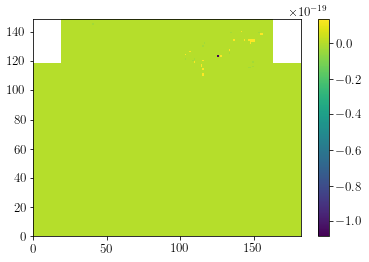

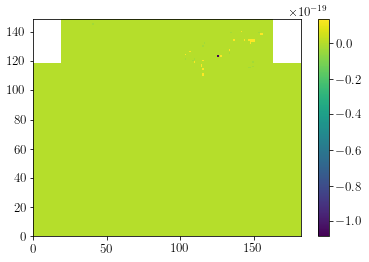

In [48]:
flxcorr = 5.5
hosing = True
fdi = forcdir(flxcorr,False,1990,hosing,0.3)

tdir = f'/gpfs/data/greenocean/software/products/ARIA-atmo-forcing/{fdi}'
print(tdir)
y = 1990; yr = 1990
snowtest = xr.open_dataset(f'{tdir}/era5_bulk_14_y{y}.nc', decode_times=False)
raintest = xr.open_dataset(f'{tdir}/era5_bulk_13_y{y}.nc', decode_times=False)
randtest = xr.open_dataset(f'{tdir}/era5_bulk_15_y{y}.nc', decode_times=False)

edir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
snowbase = xr.open_dataset(f'{edir}/era5_bulk_14_y{y}.nc', decode_times=False)
rainbase = xr.open_dataset(f'{edir}/era5_bulk_13_y{y}.nc', decode_times=False)
randbase = xr.open_dataset(f'{edir}/era5_bulk_15_y{y}.nc', decode_times=False)

print(is_leap_year(y))

hosfact = 0
if hosing: hosfact = 1
        # try:  w['prra'] = w['prra'] + ((-1 * lyflx) + lyhos)
        # except: w['prra'] = w['prra'] + ((-1 * nlyflx) + nlyhos)
        

if (is_leap_year(y)):
    fc_hos = (-1 * flxcor.lydiff.values * flxcorr) + hos3.lyhos.values * hosfact
    fc_sno = (-1 * flxcor.lydiff.values * flxcorr) + hos3.lyhos.values * 0
else:
    fc_hos = (-1 * flxcor.nlydiff.values * flxcorr) + hos3.nlyhos.values * hosfact
    fc_sno = (-1 * flxcor.nlydiff.values * flxcorr) + hos3.nlyhos.values * 0
    
rain_test2base = (raintest.prra.values - fc_hos) - rainbase.prra.values
snow_test2base = (snowtest.prsn.values - fc_sno) - snowbase.prsn.values

print(np.nanmax(rain_test2base))
print(np.nanmin(rain_test2base))
print(np.nanmax(snow_test2base))
print(np.nanmin(snow_test2base))
plt.figure()
q = plt.pcolormesh(rain_test2base[0,:,:])
plt.colorbar(q)
plt.figure()
q = plt.pcolormesh(rain_test2base[0,:,:])
plt.colorbar(q)

ERA5_UHOSE0pt3Sv_flxcorr5pt5x/
/gpfs/data/greenocean/software/products/ARIA-atmo-forcing/ERA5_UHOSE0pt3Sv_flxcorr5pt5x/
False
0.0
0.0


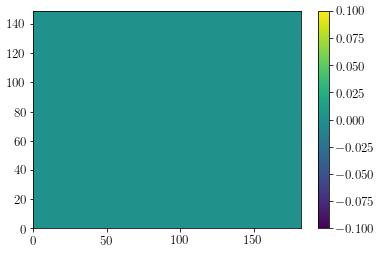

In [52]:
flxcorr = 5.5
hosing = True
fdi = forcdir(flxcorr,False,1990,hosing,0.3)

tdir = f'/gpfs/data/greenocean/software/products/ARIA-atmo-forcing/{fdi}'
print(tdir)
y = 1990; yr = 1990
snowtest = xr.open_dataset(f'{tdir}/era5_bulk_14_y{y}.nc', decode_times=False)
raintest = xr.open_dataset(f'{tdir}/era5_bulk_13_y{y}.nc', decode_times=False)
randtest = xr.open_dataset(f'{tdir}/era5_bulk_11_y{y}.nc', decode_times=False)

edir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
snowbase = xr.open_dataset(f'{edir}/era5_bulk_14_y{y}.nc', decode_times=False)
rainbase = xr.open_dataset(f'{edir}/era5_bulk_13_y{y}.nc', decode_times=False)
randbase = xr.open_dataset(f'{edir}/era5_bulk_11_y{y}.nc', decode_times=False)

print(is_leap_year(y))

hosfact = 0
if hosing: hosfact = 1
        # try:  w['prra'] = w['prra'] + ((-1 * lyflx) + lyhos)
        # except: w['prra'] = w['prra'] + ((-1 * nlyflx) + nlyhos)
        

if (is_leap_year(y)):
    fc_hos = (-1 * flxcor.lydiff.values * flxcorr) + hos3.lyhos.values * hosfact
    fc_sno = (-1 * flxcor.lydiff.values * flxcorr) + hos3.lyhos.values * 0
else:
    fc_hos = (-1 * flxcor.nlydiff.values * flxcorr) + hos3.nlyhos.values * hosfact
    fc_sno = (-1 * flxcor.nlydiff.values * flxcorr) + hos3.nlyhos.values * 0
    
rand_test2base = (randbase.rsds.values) - (randtest.rsds.values)
#snow_test2base = (snowtest.rsds.values - fc_sno) - snowbase.prsn.values

print(np.nanmax(rand_test2base))
print(np.nanmin(rand_test2base))

plt.figure()
q = plt.pcolormesh(rand_test2base[0,:,:])
plt.colorbar(q)


In [51]:
randbase

<xarray.Dataset>
Dimensions:       (time_counter: 365, x: 182, y: 149)
Coordinates:
  * time_counter  (time_counter) float32 9.969e+36 9.969e+36 ... 9.969e+36
Dimensions without coordinates: x, y
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    deptht        (y, x) float32 ...
    rsds          (time_counter, y, x) float32 ...